This notebook is dedicated for task 1: part 1 and 2. 

In part 1, we are finding the specific date range of this anomaly, using visual and statistical methods, namely the z-score. 

In part 2, we are discussing potential methods to automatically detect such anomalies in a scenario where no labels are available. We also are going to implement one method (the Isolation forest). 

In this task, we are not doing extensive EDA, this should take place in task 2. We are more fosuced here on registration time, together with the is_fraud indication. 

# Task 1, part 1

In [39]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [77]:
#load data
df = pd.read_csv('../data/Dataset Home Task Data Scientist.csv')

In [41]:
df.head(2)

,user_id,registration_timestamp,email_domain,age,gender,job_title,education_level,is_smoker,is_drinker,os,device_type,registration_duration_ms,is_fraud
0,b15f6943-a626-4421-bf75-920479d48382,2025-01-01T00:00:02.650012,gmail.com,45,F,Junior,High School,False,True,ios,mobile,12441.110944,False
1,9ab3bcb0-3684-412e-b670-dabbe23677ef,2025-01-01T00:01:21.914078,gmail.com,30,M,Mid-Level,High School,False,False,windows,desktop,14321.539458,False


In [42]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   50000 non-null  str    
 1   registration_timestamp    50000 non-null  str    
 2   email_domain              50000 non-null  str    
 3   age                       50000 non-null  int64  
 4   gender                    50000 non-null  str    
 5   job_title                 50000 non-null  str    
 6   education_level           45105 non-null  str    
 7   is_smoker                 50000 non-null  bool   
 8   is_drinker                50000 non-null  bool   
 9   os                        50000 non-null  str    
 10  device_type               50000 non-null  str    
 11  registration_duration_ms  50000 non-null  float64
 12  is_fraud                  50000 non-null  bool   
dtypes: bool(3), float64(1), int64(1), str(8)
memory usage: 4.0 MB


In [43]:
df.shape

(50000, 13)

In [44]:
#parsing the timestamp
df['registration_timestamp'] = pd.to_datetime(df['registration_timestamp'])

In [45]:
df['registration_timestamp'].head()

0   2025-01-01 00:00:02.650012
1   2025-01-01 00:01:21.914078
2   2025-01-01 00:02:31.383339
3   2025-01-01 00:02:44.511087
4   2025-01-01 00:04:06.897122
Name: registration_timestamp, dtype: datetime64[us]

In [46]:
#date range
print(f"date range: {df['registration_timestamp'].min()} to {df['registration_timestamp'].max()}")

date range: 2025-01-01 00:00:02.650012 to 2025-01-30 23:58:09.521776


In [47]:
#extract days
df['date'] = df['registration_timestamp'].dt.date
#df['hour'] = df['registration_timestamp'].dt.hour
#df['day_of_week'] = df['registration_timestamp'].dt.dayofweek

In [48]:
df['date'].head()

0    2025-01-01
1    2025-01-01
2    2025-01-01
3    2025-01-01
4    2025-01-01
Name: date, dtype: object

In [49]:
# calculate fraud statistic
daily_stats = df.groupby('date').agg({'is_fraud': ['sum', 'count', 'mean']}).reset_index()

In [50]:
daily_stats.head()

date is_fraud                
                   sum count      mean
0  2025-01-01       65  1681  0.038667
1  2025-01-02       54  1612  0.033499
2  2025-01-03       63  1655  0.038066
3  2025-01-04       71  1661  0.042745
4  2025-01-05       69  1671  0.041293

In [51]:
#rename columns for more clarity
daily_stats.columns = ['date', 'fraud_count', 'total_registrations', 'fraud_rate']

In [52]:
daily_stats.head()

,date,fraud_count,total_registrations,fraud_rate
0,2025-01-01,65,1681,0.038667
1,2025-01-02,54,1612,0.033499
2,2025-01-03,63,1655,0.038066
3,2025-01-04,71,1661,0.042745
4,2025-01-05,69,1671,0.041293


In [53]:
daily_stats.head(2)

,date,fraud_count,total_registrations,fraud_rate
0,2025-01-01,65,1681,0.038667
1,2025-01-02,54,1612,0.033499


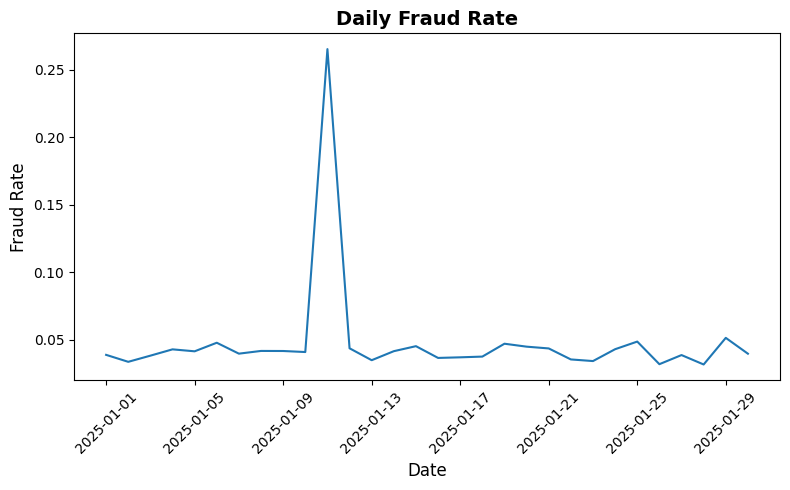

In [54]:
# plot fraud per day
plt.figure(figsize = (8, 5))
plt.plot(daily_stats['date'], daily_stats['fraud_rate'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.title('Daily Fraud Rate', fontsize=14, fontweight='bold')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('../outputs/plots/daily_fraud_rate_timeline.png')
plt.show()


In [ ]:
#from the visual above, we can estimate the range where the anomaly reside, let's verify this with statistic

In [55]:
# z scores for daily fraud rates
mean_fraud_rate = daily_stats['fraud_rate'].mean()
std_fraud_rate = daily_stats['fraud_rate'].std()
daily_stats['z_score'] = (daily_stats['fraud_rate'] - mean_fraud_rate) / std_fraud_rate

In [56]:
# we define anomaly threshold as 2.5 of the std
threshold = 2.5
daily_stats['is_anomaly'] = daily_stats['z_score'] > threshold

In [57]:
daily_stats.head(2)

,date,fraud_count,total_registrations,fraud_rate,z_score,is_anomaly
0,2025-01-01,65,1681,0.038667,-0.220959,False
1,2025-01-02,54,1612,0.033499,-0.345834,False


In [58]:
print("statistical analysis")
print(f"mean fraud rate: {mean_fraud_rate:.2f}")
print(f"std: {std_fraud_rate:.2f}")
print(f"anomaly threshold (mean + {threshold}): {mean_fraud_rate + threshold * std_fraud_rate:.2f}")

statistical analysis
mean fraud rate: 0.05
std: 0.04
anomaly threshold (mean + 2.5): 0.15


In [59]:
anomalous_days = daily_stats[daily_stats['is_anomaly']]

In [60]:
len(anomalous_days)

1

In [61]:
print(anomalous_days[['date', 'fraud_rate', 'z_score', 'fraud_count', 'total_registrations']].to_string(index=False))

      date  fraud_rate  z_score  fraud_count  total_registrations
2025-01-11    0.265401 5.256873          573                 2159


In [62]:
anomaly_dates = daily_stats[daily_stats['is_anomaly']]['date'].tolist()

In [28]:
anomaly_dates

[datetime.date(2025, 1, 11)]

## Anomaly period detected: 

Anomalous Period: January 11, 2025
Duration: 1 day
Fraud Rate: .26
Statistical Evidence: z score= 5.257 > 2.5 (highly significant outlier)

## Task 1, part 2: 

Anomaly detection without labels and implementation -- discussion

In part 1, we successfully identified the anomalous period (January 11, 2025) using the is_fraud label.

However, in a real world production scenario, we often don't have fraud labels immediately available. We need unsupervised methods to detect anomalies based on behavioral patterns alone.

This section explores a few approaches for anomaly detection without labeled data.

### Potential methods:

1.**Statistical Time Series Monitoring**:

Monitor behavioral metrics over time, flag periods exceeding statistical thresholds. This method is fast and interpretable, but it assumes normality

2.**Isolation forest (demonstrated below)**:

This is an unsupervised ML on multivariate patterns. It detects outliers in behavioral space

3.**Other Approaches**:

Clustering based models (k-means, DBSCAN (Density-Based Spatial Clustering of Applications with Noise))

Autoencoders


### Isolation forest demontration

In [68]:
# create behavioral metrics without using is_fraud
behavioral_metrics = df.groupby('date').agg({
    'registration_duration_ms': ['mean', 'std'],
    'user_id': 'count',
    'email_domain': 'nunique',
    'device_type': lambda x: (x=='mobile').sum()/len(x)
})

In [69]:
behavioral_metrics.head()

registration_duration_ms              user_id email_domain  \
                               mean          std   count      nunique   
date                                                                    
2025-01-01             14966.136053  2053.363814    1681            4   
2025-01-02             15041.599652  2069.786676    1612            4   
2025-01-03             14943.504415  2067.509669    1655            4   
2025-01-04             15019.449304  1973.429083    1661            4   
2025-01-05             14989.081705  2009.865846    1671            4   

           device_type  
              <lambda>  
date                    
2025-01-01    0.426532  
2025-01-02    0.404467  
2025-01-03    0.378248  
2025-01-04    0.406984  
2025-01-05    0.408737

In [ ]:
#Isolation forest model from sklearn
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.05)
predictions = iso_forest.fit_predict(behavioral_metrics)

In [72]:
#which days are flagged as anomalous
anomalous_dates = behavioral_metrics[predictions == -1]

In [73]:
anomalous_dates

registration_duration_ms              user_id email_domain  \
                               mean          std   count      nunique   
date                                                                    
2025-01-03             14943.504415  2067.509669    1655            4   
2025-01-11             15012.853870  2033.147600    2159            4   

           device_type  
              <lambda>  
date                    
2025-01-03    0.378248  
2025-01-11    0.540065

11.01.2025 is flagged as anomaly, using the Isolation Forest method, further investigations or implementation of other methods, to comfirm the results, and to check whether the other days flagged as anomalies are also anomalies, or it is just a false positive using isolation forest.  